<html id="* graph_euler_method">
	<author>Hiroshi TAKEMOTO</author>
	(<email>take@pwv.co.jp</email>)
	
	<h1>Sageでグラフを再現してみよう：データ解析のための統計モデリング入門第６章</h1>
	<p>
		この企画は、雑誌や教科書にでているグラフをSageで再現し、
		グラフの意味を理解すると共にSageの使い方をマスターすることを目的としています。
	</p>
	<p>
		前回に続き、<a href="http://www.amazon.co.jp/dp/400006973X/">データ解析のための統計モデリング入門</a>
		（以下、久保本と書きます）
		の第6章の例題をSageを使って再現してみます。
	</p>
	<p>
		数式処理システムSageのノートブックは、計算結果を表示するだけではなく、実際に動かすことができるのが大きな特徴です。
		この機会にSageを分析に活用してみてはいかがでしょう。
	</p>
</html>

<html>
	<h2>前準備</h2>
	<p>
		最初に必要なライブラリーやパッケージをロードしておきます。
	</p>
</html>

In [1]:
# RとPandasのデータフレームを相互に変換する関数を読み込む
# Rの必要なライブラリ
r('library(ggplot2)')
r('library(jsonlite)')

# python用のパッケージ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
# statsmodelsを使ってglmを計算します
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats.stats import pearsonr
%matplotlib inline

# jupyter用のdisplayメソッド
from IPython.display import display, Latex, HTML, Math, JSON
# sageユーティリティ
load('script/sage_util.py')
# Rユーティリティ
load('script/RUtil.py')

<html>
	<h2>上限のあるカウントデータの回帰分析</h2>
	<p>
		6章の最初に二項分布を使った回帰分析の例がでてきます。ポアソン分布では上限のないカウントデータでしたが、
		上限のある場合には、二項分布を使うのだと説明がありました。
		（自然界ではこのように上限のあるカウントデータが多いので、とても参考になりました）
	</p>
</html>

<html>
	<h3>二項分布用のデータについて</h3>
	<p>
		二項分布用のデータは、サポートページにあるdata4a.csvです。
		これを読み込んで、データの性質と分布を表示します。
	</p>
	<p>
		直感的に施肥を施す(f=T)ことでサイズxが大きくなっているのが分かります。
		また、サイズと種子数の右上がりの関係が見られます。（種子数の上限は8です。）
	</p>
</html>

In [2]:
# 6章のデータを読み込む
d = pd.read_csv('data/data4a.csv')
d.head()

,N,y,x,f
0,8,1,9.76,C
1,8,6,10.48,C
2,8,5,10.83,C
3,8,6,10.94,C
4,8,1,9.37,C


In [3]:
d.describe()

,N,y,x
count,100.0,100.000000,100.000000
mean,8.0,5.080000,9.967200
std,0.0,2.743882,1.088954
min,8.0,0.000000,7.660000
25%,8.0,3.000000,9.337500
50%,8.0,6.000000,9.965000
75%,8.0,8.000000,10.770000
max,8.0,8.000000,12.440000


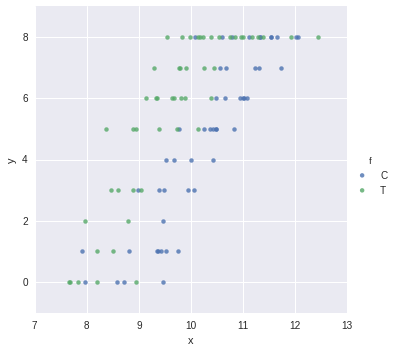

In [4]:
# F別の分布をみる
sns.lmplot('x', 'y', data=d, hue='f', fit_reg=False )
plt.show()

<html>
	<h3>二項分布</h3>
	<p>
		ここで、Sageのプロット関数を使って二項分布の確率分布がどのような形になっているか
		久保本の図6.3と同じ条件でブロットしてみます。
	</p>
	<p>
		二項分布を
$$
	p(y | N, q) = \binom{N}{y} q^y (1 -q)^{N-y}
$$		
		以下の様に_p関数で定義します。
	</p>
	<p>
		Sageでプロットしてみます。Sageではグラフ（Graphics）にグラフを足すことで、重ね合わせのプロットができます。
		とても直感的にグラフを書くことができます。（ggplotも同じです）
	</p>
</html>

In [5]:
# 二項分布を定義
def _p(q, y, N):
    return binomial(N, y)*q^y*(1-q)^(N-y)

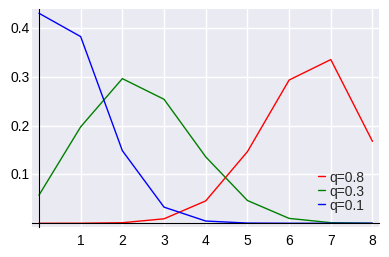

In [6]:
g = Graphics()
g += list_plot([_p(0.8, y, 8) for y in (0..8)], plotjoined=True, rgbcolor="red", legend_label ="q=0.8")
g +=  list_plot([_p(0.3, y, 8) for y in (0..8)], plotjoined=True, rgbcolor="green", legend_label ="q=0.3")
g +=  list_plot([_p(0.1, y, 8) for y in (0..8)], plotjoined=True, rgbcolor="blue", legend_label ="q=0.1")
g.show(figsize=4)

<html>
	<h3>ロジスティック関数</h3>
	<p>
		ロジスティック関数
$$
		q_i = logistic(z_i) = \frac{1}{1 + exp(-z_i)}
$$		
		の関数を_logisticとして定義し、その分布をSageを使ってプロットします。
	</p>
	<p>
		ロジスティック関数のような曲線を持つデータの場合には、二項分布の確率分布があると予測して回帰分析を行います。
		リンク関数は、ロジスティック関数の逆関数であるロジットリンク関数を指定します。
	</p>
	<p>
		ロジット関数は、以下の様に表されます(式a)。
$$
		logit(q_i) = log \frac{q_i}{1 - q_i}
$$		
	</p>
</html>

In [7]:
# ロジスティック関数の定義
def _logistic(z):
    return 1/(1 + exp(-z))

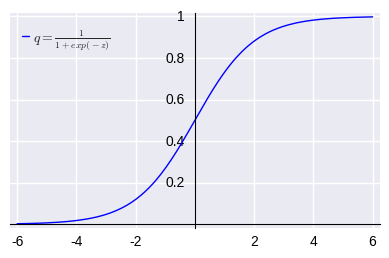

In [8]:
# ロジスティック曲線
plot(_logistic(x), [x, -6, 6], figsize=4, legend_label='$q=\\frac{1}{1+exp(-z)}$')

<html>
	<h3>パラメータ推定</h3>
	<p>
		残念ながら、statmodelsではcbindに相当する二項分布の解析方法が分からず、
		Rを使って計算することにしました。
	</p>
	<p>
		Sageの中からRの関数を使うことができるので、計算を中断することなく進めることができます。
	</p>
	<p>
		回帰の結果、$\beta_1 = -19.536, \beta_2 = 1.95, \beta_3=2.02$と求まりました。
	</p>
</html>

In [9]:
# statmodelsでcbind(y, N -y)の部分を表現する方法が見つからなかった
# 0, 1の場合には、statmodelsでも解析可能です。
# 残念ですが、Rを使って処理します。
PandaDf2RDf(d, "d")

In [10]:
r('glm(cbind(y, N - y) ~ x + f, data=d, family=binomial)')


Call:  glm(formula = cbind(y, N - y) ~ x + f, family = binomial, data = d)

Coefficients:
(Intercept)            x           fT  
    -19.536        1.952        2.022  

Degrees of Freedom: 99 Total (i.e. Null);  97 Residual
Null Deviance:	    499.2 
Residual Deviance: 123 	AIC: 272.2

<html>
	<h3>結果の図化</h3>
	<p>
		Sageを使って解析結果、施肥あり$logistic(-19.536+1.952x + 2.022)$、施肥なし$logistic(-19.536+1.952x)$をプロットしました。
	</p>
</html>

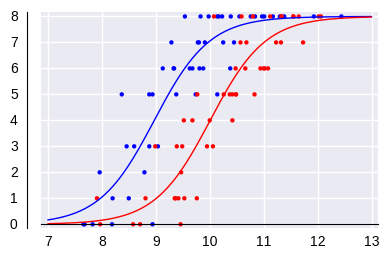

In [11]:
dT = d[d.f == 'T']
dC = d[d.f == 'C']
dT_pts = list_plot(zip(dT.x, dT.y), zorder=2)
dC_pts = list_plot(zip(dC.x, dC.y), zorder=2, rgbcolor='red')
dT_plt = plot(_logistic(-19.536+1.952*x + 2.022)*8, [x, 7, 13])
dC_plt = plot(_logistic(-19.536+1.952*x)*8, [x, 7, 13], rgbcolor='red')
(dT_pts+dT_plt+dC_pts+dC_plt).show(figsize=4)

<html>
	<h3>結果の解釈</h3>
	<p>
		久保本のすごいところは、単に回帰をすることで終わらず、その解釈を説明しているところです。
		リンク関数がロジット関数である(式a)であることから
$$
		log \frac{q_i}{1 - q_i} = \beta_1 + \beta_2 x_i + \beta_3 f_i
$$		
		となり、両辺の指数を取ると、
$$
		\frac{q_i}{1 - q_i} = exp(\beta_1 + \beta_2 x_i + \beta_3 f_i) 
							= exp(\beta_1) exp(\beta_2 x_i) exp(\beta_3 f_i)
$$		
		となります。$\frac{q_i}{1 - q_i}$がオッズと呼ばれる量です。
	</p>
	<p>
		施肥の有無による違いは、exp(2.02)=7.5倍であると推定されました。
	</p>
</html>

<html>
	<h2>割り算を使わない方法はすごい！</h2>
	<p>
		久保本の6章で感動したのは、割り算を使わない方法です。
		私のようなものは、割り算を使って正規化してしまいますが、
		このように割り算をしないで、回帰分析する方法としてオフセット項の使い方を
		紹介しています。
	</p>
	<p>
		オフセット用のデータには、data4b.csvを使います。
		このデータは、
		<ul>
			<li>調査地iの面積を$A_i$</li>
			<li>調査地iの明るさを$x_i$</li>
			<li>調査地iにおける植物個体数$y_i$</li>
		</ul>
		の記録です。横軸にA, 縦軸にyを取りデータをプロットすると以下の様になります。
		面積が大きいほど植物個体数が多く、xが大きい（明るい）程植物個体数が多いことが
		見て取れます。
	</p>
	<p>
		オフセット項は、offset=np.log(オフセットのカラム)のように指定します。ここでは、オフセット値Aのlogを
		取った値が使われていますが、これは以下のような理由からです。
	</p>
	<p>
		人口密度を以下の様に表し、
$$
		\frac{平均個体数\lambda_i}{A_i} = 人口密度
$$		
		平均個体数と明るさに指数関数的な関係があると仮定すると、
$$
		\lambda_i = A_i \times 人口密度 = A_i exp(\beta_1 + \beta_2 x_i)
$$		
		ここで、面積を掛けている部分にlogを使うことで
$$
		\lambda_i  = exp(\beta_1 + \beta_2 x_i + log A_i)
$$		
		と変形することができます。つまり、$log A_i$だけずれた値（オフセット項）、久保本では「げた」をはかせたと考えると
		よいとありました。
	</p>
</html>

In [12]:
# オフセット用のデータを読み込む
d2 = pd.read_csv('data/data4b.csv')
d2.head()

,y,x,A
0,57,0.68,10.3
1,64,0.27,15.6
2,49,0.46,10.0
3,64,0.45,14.9
4,82,0.74,14.0


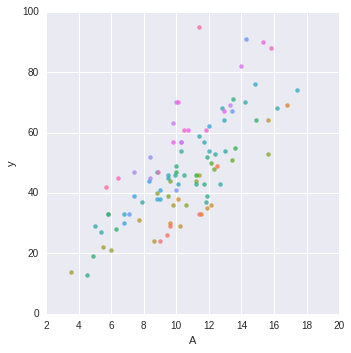

In [13]:
# Aの値で色を変えてプロット
sns.lmplot('A', 'y', data=d2, hue='x', fit_reg=False, legend=False)
plt.show()

<html>
	<h3>推定値</h3>
	<p>
		推定された値をプロットすると以下のようになります。
		データよりもはっきりと明るさによる影響がきれいに分かります。（そのようにモデルを作ったので当たり前なのですが）
	</p>
</html>

In [14]:
fit = smf.glm('y ~ x', data=d2, offset=np.log(d2.A), family=sm.families.Poisson(link=sm.families.links.log)).fit()
fit.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
==============================================================
Model:              GLM              AIC:            650.3406 
Link Function:      log              BIC:            -369.6983
Dependent Variable: y                Log-Likelihood: -323.17  
Date:               2016-07-17 10:01 LL-Null:        -413.09  
No. Observations:   100              Deviance:       81.608   
Df Model:           1                Pearson chi2:   81.5     
Df Residuals:       98               Scale:          1.0000   
Method:             IRLS                                      
---------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept     0.9731    0.0451  21.5999  0.0000  0.8848  1.0614
x             1.0383    0.0777  13.3638  0.0000  0.8860  1.1905
==============================================================

"""

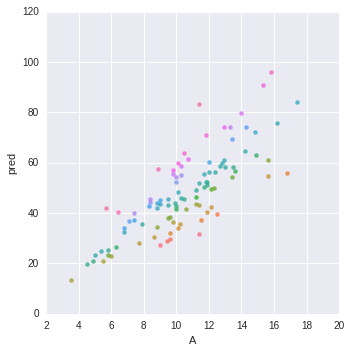

In [15]:
d2['pred'] = fit.predict()
# xの値で色を変えてプロット
sns.lmplot('A', 'pred', data=d2, hue='x', fit_reg=False, legend=False)
plt.show()

<html>
	<h2>正規分布と尤度</h2>
	<p>
		Sageにも確率分布を扱う関数RealDistirubtionがVer.5から導入されました。（まだ一部の関数のサポートですが）
		これを使って、正規分布の確率密度関数をプロットしていました。
	</p>
</html>

In [16]:
# Sage ver.5から導入されたRealDistributionを使う
T1 = RealDistribution('gaussian', 1, seed=101)
T2 = RealDistribution('gaussian', 3, seed=101)

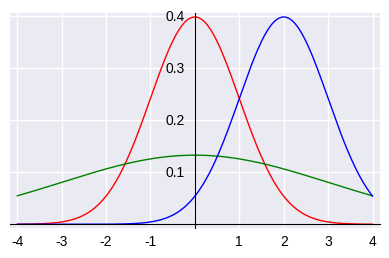

In [17]:
T1_plt = plot(lambda x : T1.distribution_function(x), [x, -4, 4], rgbcolor="red")
T2_plt = plot(lambda x : T2.distribution_function(x), [x, -4, 4], rgbcolor="green")
T3_plt = plot(lambda x : T1.distribution_function(x-2), [x, -4, 4], rgbcolor="blue")
(T1_plt + T2_plt + T3_plt).show(figsize=4)

<html>
	<h3>確率密度関数から確率を得る</h3>
	<p>
		確率密度関数から指定された範囲に含まれる確率は、その範囲の面積になります。（その範囲で積分した値）
		cum_distribution_functionは、マイナス無限大から指定された値までの確立を計算するので、
		この関数の差を計算することで、指定範囲の確率（面積）を求めることができます。
	</p>
</html>

In [18]:
# xが1.2から1.8となる確率は、cum_distribution_functionの差で計算で求まる
T1.cum_distribution_function(1.8) - T1.cum_distribution_function(1.2)

0.07913935110878245

<html>
	<h3>正規分布の尤度</h3>
	<p>
		久保本に従って正規分布の尤度をと最尤尤度を求めてみます。
		$y_iがy_i - 0.5\Delta y \leq y \leq y_i + 0.5\Delta y$である確率は、
$$
		\begin{eqnarray}
			L(\mu, \sigma) & = &  \prod_i p(y_i | \mu, \sigma) \Delta y \\
				& = & \prod_i \frac{1}{\sqrt{2 \pi \sigma^2}} exp\left\{ \frac{(y_i - \mu)^2}{2\sigma^2} \right\} \Delta y \\
				& = & \prod_i (2 \pi \sigma^2)^{-\frac{1}{2}} exp\left\{ \frac{(y_i - \mu)^2}{2\sigma^2} \right\} \Delta y
		\end{eqnarray}
$$	
		両辺をlogを取って
$$
\begin{eqnarray}
	log L(\mu, \sigma)  & = & -\frac{1}{2} \sum_i log(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_i (y_i - \mu)^2 + \sum_i log(\Delta y) \\
						& = & -\frac{1}{2} N log(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_i (y_i - \mu)^2 + N log(\Delta y) 
\end{eqnarray}
$$
		$\Delta y$の項を無視すると、
$$
	log L(\mu, \sigma) = -\frac{1}{2} N log(2 \pi \sigma^2) - \frac{1}{2 \sigma^2} \sum_i (y_i - \mu)^2
$$		
		となります。これを$\mu$で偏微分し、最小となるのは、$y = \mu$と求まります。（最小自乗法の解と同じ）
	</p>
</html>

<html>
	<h2>ガンマ分布</h2>
	<p>
		どんなときにガンマ分布を使うのかGoogleでみると、正の値で、寿命や待ち時間など経過時間に無関係一定値の場合に、
		使われるとありました。
	</p>
	<p>
		ガンマ分布をSageでプロットしてみます。
	</p>
</html>

In [19]:
# Rの乱数の種をセット
r('set.seed(101)')
# Rのdgammaを使用
def _gamma(y, shape, rate):
    return sageobj(r('dgamma(%s, %s, %s)' %(y, shape, rate)))

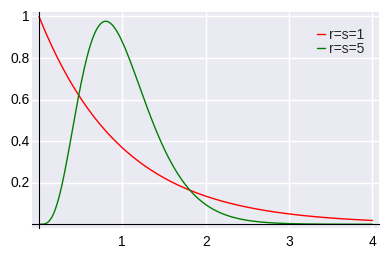

In [20]:
g = Graphics()
g += plot(lambda x: _gamma(x, 1, 1), [x, 0, 4], rgbcolor="red", legend_label ="r=s=1")
g += plot(lambda x: _gamma(x, 5, 5), [x, 0, 4], rgbcolor="green", legend_label ="r=s=5")
#g += plot(lambda x: _gamma(x, 0.1, 0.1), [x, 0, 4], rgbcolor="blue", legend_label ="r=s=0.1")
g.show(figsize=4)

<html>
	<h3>ガンマ分布を使った回帰分析</h3>
	<p>
		例題では、ある個体の花の重量を$y_i$が平均$\mu_i$のガンマ分布にしたがっていると仮定します。
$$
		\mu_i = A x_i^b
$$		
		で、A=exp(a)とすると、
$$
		\mu_i = exp(a)x_i^b = exp(a + log x_i^b) = exp(a + b log x_i)
$$		
		と表され、リンク関数は、expの逆関数のlogとなり、
$$
		log \mu_i = a + b log x_i
$$		
		となります。
	</p>
	<p>
		ガンマ分布の例題データは、RData形式なので、Rで解析します。family=Gamma(link="log")でリンク関数logのガンマ分布を指定します。
	</p>
	<p>
		glmを使うと複雑な分布の回帰が簡単に計算できます。しかし、どのモデルが良いかは、
		プロット結果を見ながら判断するのがよいと実感しました。人間の目で分からない違いは、尤度やAICを使うのが現実できなのでは？
	</p>
</html>

In [21]:
# ガンマ分布用のデータを使って回帰分析
r('load("data/d.RData")')
r('glm(y ~ log(x), family=Gamma(link="log"), data=d)')


Call:  glm(formula = y ~ log(x), family = Gamma(link = "log"), data = d)

Coefficients:
(Intercept)       log(x)  
    -1.0403       0.6833  

Degrees of Freedom: 49 Total (i.e. Null);  48 Residual
Null Deviance:	    35.37 
Residual Deviance: 17.25 	AIC: -110.9

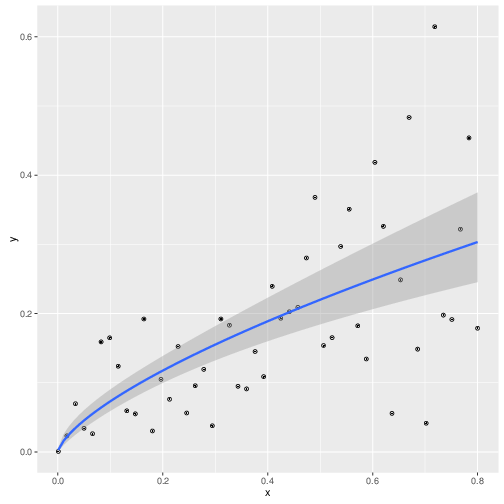

In [23]:
# 結果の図化、stat_smoothのglmを使う場合、method.argsにfamilyをセットするのに変わったみたい。
graph = preGraph("images/fig-6.13.pdf")
r('p <- ggplot(data=d, aes(x=x, y=y)) + geom_point() + stat_smooth(method=glm, formula=y ~ log(x), method.args = list(family=Gamma(link="log")))')
r('plot(p)')
postGraph(graph)